In [19]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import torch
from torch.utils.data import TensorDataset

batch_size = 64

# Download SVHN dataset
X_train = np.load('./data/SVHN_npy/X_train.npy')
y_train = np.load('./data/SVHN_npy/y_train.npy')

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train).permute(3,0,1,2)
y_train_tensor = torch.Tensor(y_train)

# Create a TensorDataset for training data
svhn_dataset = TensorDataset(X_train_tensor, y_train_tensor)



In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random

# Download MNIST dataset
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, mnist_dataset, svhn_dataset, missing_prob=0.05):
        self.mnist_dataset = mnist_dataset
        self.svhn_dataset = svhn_dataset
        self.missing_prob = missing_prob
        self.targets = torch.empty_like(mnist_dataset.targets)

        # Find how many instances of each class in MNIST
        tgt_counts = torch.empty_like(torch.unique(mnist_dataset.targets))
        for i in range(torch.unique(mnist_dataset.targets).shape[0]):
            tgt_counts[i] = torch.sum(mnist_dataset.targets == i)

        # Find how many instances of each class in SVHN
        tgt_counts2 = torch.empty_like(torch.unique(svhn_dataset.tensors[1]))
        for i in range(torch.unique(svhn_dataset.tensors[1]).shape[0]):
            tgt_counts2[i] = torch.sum(svhn_dataset.tensors[1] == i)

        assert len(tgt_counts) == len(tgt_counts2)

        # For every data point in MNIST, we sample a point in SVHN of the same class and add it to svhn_ordered
        tgt_counts_cum = torch.cumsum(tgt_counts, dim=0)
        self.svhn_ordered = torch.empty(size=(torch.sum(tgt_counts), *svhn_dataset.tensors[0][0].shape))
        for target, nsamples in enumerate(tgt_counts):
            data = svhn_dataset[svhn_dataset.tensors[1].squeeze(1) == target]
            indeces = torch.randint(data[1].shape[0], size=(int(nsamples), 1)).squeeze(1)
            for j in range(nsamples):
                if target == 0:
                    self.svhn_ordered[j] = data[0][indeces[j]]
                    self.targets[j] = torch.tensor(target)
                else:
                    self.svhn_ordered[tgt_counts_cum[target-1] + j] = data[0][indeces[j]]
                    self.targets[tgt_counts_cum[target-1] + j] = torch.tensor(target)


        # We order the data points based on their class
        self.mnist_ordered = torch.tensor([])
        for target, nsamples in enumerate(tgt_counts):
            data = mnist_dataset.data[mnist_dataset.targets == target]
            assert len(data) == nsamples
            self.mnist_ordered = torch.cat([self.mnist_ordered, data])

        self.mnist_ordered = self.mnist_ordered.unsqueeze(3)


    def __len__(self):
        return len(self.mnist_ordered)

    def __getitem__(self, idx):
        mnist_img = self.mnist_ordered[idx]
        svhn_img = self.svhn_ordered[idx]

        # Randomly decide which feature to mask with probability missing_prob
        if random.random() < self.missing_prob:
            # Mask MNIST image
            mnist_img = torch.zeros_like(mnist_img)
        elif random.random() < self.missing_prob:
            # Mask SVHN image
            svhn_img = torch.zeros_like(svhn_img)
        return (mnist_img, svhn_img), self.targets[idx]

# Data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST and SVHN datasets
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)


# Create a custom dataset
custom_dataset = CustomDataset(mnist_dataset, svhn_dataset, missing_prob=0.05)

# Create a DataLoader for the custom dataset
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


Labels: - 5 - 9 - 9 - 8 - 7 - 1 - 6 - 4 - 8 - 0 - 

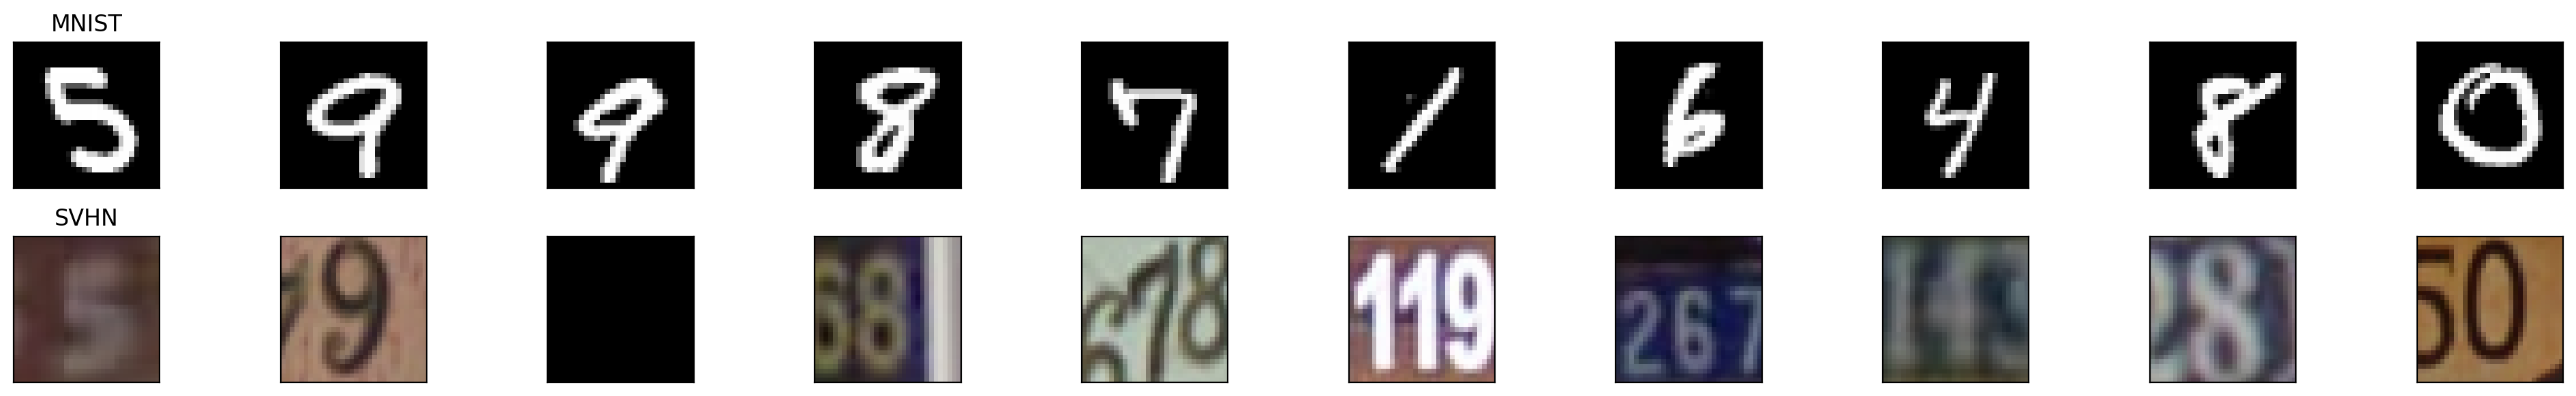

torch.Size([1, 1, 1, 28, 28, 1])
torch.Size([1, 1, 1, 32, 32, 3])


In [21]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

# Create a subplot with 2 rows and n columns
n = 10
fig, axes = plt.subplots(2, n)

print('Labels: ', end='- ')
for i in range(n):
    sample = torch.randint(0, len(custom_dataset), size=(1,1)).unsqueeze(1)
    (mnist, svhn), label = custom_dataset[sample]
    # Display the first image on the top
    axes[0,i].imshow(mnist.squeeze(), cmap='gray')  # Use 'cmap' if images are grayscale
    axes[0,i].get_xaxis().set_visible(False)
    axes[0,i].get_yaxis().set_visible(False)
    # Display the second image on the bottom
    axes[1,i].imshow(svhn.squeeze())
    axes[1,i].get_xaxis().set_visible(False)
    axes[1,i].get_yaxis().set_visible(False)
    if i==0:
        axes[0,i].set_title('MNIST')
        axes[1,i].set_title('SVHN')
    print(int(label.squeeze()), end=' - ')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(mnist.shape)
print(svhn.shape)

In [22]:
from collections import OrderedDict
from torch import nn

class encoder(nn.Module):
    
    def __init__(self,dimz,channels1=1, channels2=3,var_x=0.1):
        
        super().__init__()

        self.device = torch.device("cuda:0")

        self.dimz = dimz

        self.mnist_encoder = nn.Sequential(OrderedDict([
            ('Conv1',nn.Conv2d(in_channels=channels1, out_channels=32, kernel_size=4, stride=2, padding=1)), # 28 -> 14
            ('Relu1',nn.ReLU()),
            ('Conv2',nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)), # 14 -> 7
            ('Relu2',nn.ReLU()),
            ('Conv3',nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)), # 7 -> 3
            ('Relu3',nn.ReLU()),
            ('Conv4',nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)), # 3 -> 1
            ('Relu4',nn.ReLU()),
            ('Conv5',nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1, padding=0) ), # 1 -> 1
            ('Relu5',nn.ReLU()),
        ]))

        self.svhn_encoder = nn.Sequential(OrderedDict([
            ('Conv1',nn.Conv2d(in_channels=channels2, out_channels=32, kernel_size=4, stride=2, padding=1)), # 32 -> 16
            ('Relu1',nn.ReLU()),
            ('Conv2',nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)), # 16 -> 8
            ('Relu2',nn.ReLU()),
            ('Conv3',nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)), # 8 -> 4
            ('Relu3',nn.ReLU()),
            ('Conv4',nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)), # 4 -> 2
            ('Relu4',nn.ReLU()),
            ('Conv5',nn.Conv2d(in_channels=64, out_channels=256, kernel_size=2, stride=1, padding=0) ), # 2 -> 1
            ('Relu5',nn.ReLU()),
        ]))

        self.linear_mnist = nn.Linear(256,dimz*2,device=self.device)
        self.linear_svhn = nn.Linear(256,dimz*2, device=self.device)

        # self.alpha1 = nn.Parameter(torch.randn(1, 1), requires_grad = True)
        # self.alpha2 = nn.Parameter(torch.randn(1, 1), requires_grad = True)

        self.softplus = nn.Softplus()

    def forward(self, x1, x2):
        
        x1 = x1.squeeze().unsqueeze(1)
        x2 = x2.squeeze().permute(0,3,1,2)

        # The forward method to project and image into a 2dimz dimensional vector
        
        z1 = self.mnist_encoder(x1)
        z1 = z1.view(-1,256)
        z1 = self.linear_mnist(z1)
        z2 = self.svhn_encoder(x2)
        z2 = z2.view(-1,256)
        z2 = self.linear_svhn(z2)

        return z1, z2
    
    def encode_and_sample(self, x1, x2, flag_sample=True):

        # This methods compute both the posterior mean and variance
        # Also we obtain a sample from the posterior using the
        # reparameterization trick.

        # We obtain the encoder projection using the forward method
        
        z1, z2 = self.forward(x1, x2)

        # The mean is the first dimz components of the forward output
        
        mu1 = z1[:, :self.dimz]
        mu2 = z2[:, :self.dimz]

        # We compute the variance from the last dimz components using a soft plus
        var1 = self.softplus(0.5 * z1[:, self.dimz:])
        var2 = self.softplus(0.5 * z2[:, self.dimz:])

        mu = torch.empty_like(mu1)
        var = torch.empty_like(var1)
        for i in range(mu.shape[0]):
            mu[i] = (mu1[i]@torch.diag(var1[i]) + mu2[i]@torch.diag(var2[i]))@(torch.inverse(torch.diag(var1[i])+torch.diag(var2[i])))
            var[i] = torch.diag(torch.inverse(torch.diag(var1[i]) + torch.diag(var2[i])))
        
        sample = None
        if(flag_sample==True):
            eps = torch.randn_like(var) 
            sample = mu + eps*(var**0.5)
        
        return mu,var,sample
    

In [23]:
newborn_encoder = encoder(100)
newborn_encoder.to(newborn_encoder.device)

(mnist, svhn), label = next(iter(dataloader))
mnist = mnist.to(newborn_encoder.device)
svhn = svhn.to(newborn_encoder.device)
label = label.to(newborn_encoder.device)

mu, var, z = newborn_encoder.encode_and_sample(mnist, svhn)
z.shape

torch.Size([64, 100])

In [24]:
class decoder(nn.Module):
    
    def __init__(self,dimz,channels1=1,channels2=3,var_x=0.1):
        
        super().__init__()
        
        self.device = torch.device("cuda:0")

        self.linear = nn.Linear(dimz,256, device=self.device)
        self.linear2 = nn.Linear(dimz,256, device=self.device)
        self.relu = nn.ReLU()


        self.mnist_decoder = nn.Sequential(OrderedDict([
            ('Tconv1',nn.ConvTranspose2d(256, 64, kernel_size=2, stride=1,padding=0)), # 1 -> 2
            ('Relu1',nn.ReLU()),
            ('Tconv2',nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2,padding=1)), # 2 -> 3
            ('Relu2',nn.ReLU()),
            ('Tconv3',nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1)), # 3 -> 6
            ('Relu3',nn.ReLU()),
            ('Tconv4',nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=0)), # 6 -> 14
            ('Relu4',nn.ReLU()),
            ('Tconv5',nn.ConvTranspose2d(32, channels1, kernel_size=2, stride=2,padding=0)), # 14 -> 28
            ('Relu5',nn.ReLU()),
        ]))
        self.svhn_decoder = nn.Sequential(OrderedDict([
            ('Tconv1',nn.ConvTranspose2d(256, 64, kernel_size=2, stride=1,padding=0)), # 3 -> ...
            ('Relu1',nn.ReLU()),
            ('Tconv2',nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2,padding=1)),
            ('Relu2',nn.ReLU()),
            ('Tconv3',nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2,padding=1)),
            ('Relu3',nn.ReLU()),
            ('Tconv4',nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,padding=1)),
            ('Relu4',nn.ReLU()),
            ('Tconv5',nn.ConvTranspose2d(32, channels2, kernel_size=4, stride=2,padding=1)), # ... -> 32
            ('Relu5',nn.ReLU()),
        ]))

    def forward(self,z):
        x1 = self.relu(self.linear(z).view(-1,256,1,1))
        x1 = self.mnist_decoder(x1) 
        x2 = self.relu(self.linear2(z).view(-1,256,1,1))
        x2 = self.svhn_decoder(x2) 
        return x1, x2
    
    def decode(self,z):
        return self.forward(z)

In [25]:
newborn_decoder = decoder(100)
newborn_decoder.to(newborn_decoder.device)

z = torch.randn(100, device=newborn_decoder.device)
print(z.shape)

x1, x2 = newborn_decoder.decode(z)
print(x1.shape)
print(x2.shape)

torch.Size([100])
torch.Size([1, 1, 28, 28])
torch.Size([1, 3, 32, 32])


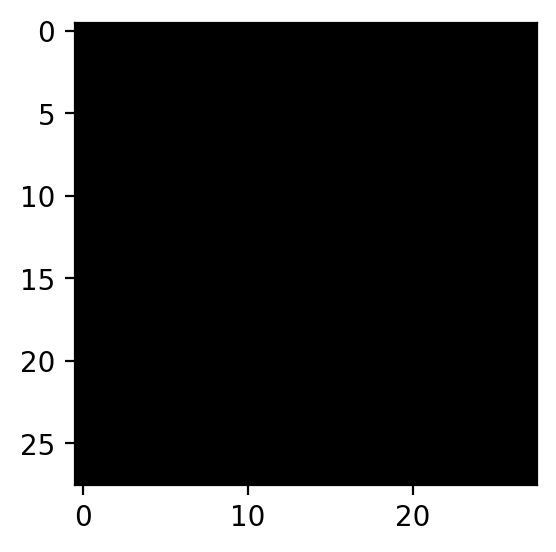

In [26]:

plt.imshow(x1.squeeze(0).permute(1,2,0).detach().cpu().numpy(), cmap='gray')


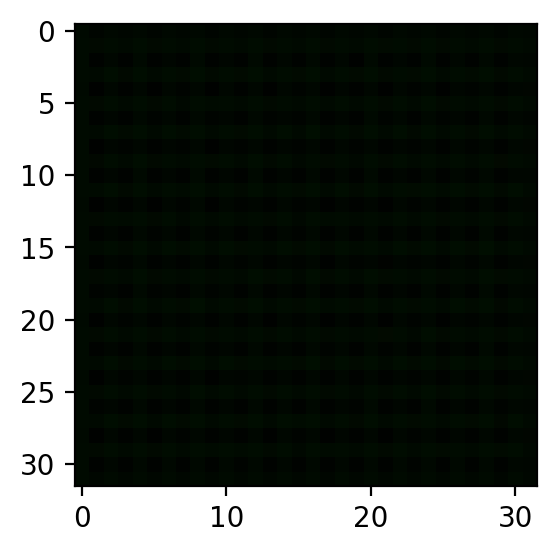

In [27]:
plt.imshow(x2.squeeze(0).permute(1,2,0).detach().cpu().numpy())


In [28]:
def eval_Gaussian_LL(x,mu_x,var_x):

    # x is a mini-batch of images. It has dimension [Batch,3,dimx,dimx]
    # mu_x is a mini-batch of reconstructed images. It has dimension [Batch,3,dimx,dimx]
    # var_x is a torch constant

    D = x.shape[1] * x.shape[2] * x.shape[3]   # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))
    
    # Accumulated Gaussian log-likelihood for all datapoints in the batch
    logp = torch.sum(logp_data)

    return logp,logp_data

In [29]:
class VAE(nn.Module):
    
    def __init__(self,dimz,channels1=1,channels2=3,var_x=0.1):
        
        super().__init__()
        
        self.var_x = var_x
        
        self.dimz = dimz

        self.encoder = encoder(self.dimz,channels1,channels2,var_x)
        self.decoder = decoder(self.dimz,channels1,channels2,var_x)
        
    def forward(self,x1,x2):

        # In the forward method, we return the mean and variance 
        # given by the encoder network and also the reconstruction mean
        # given by the decoder network using a sample from the 
        # encoder's posterior distribution.
        
        mu_z,var_z,sample_z = self.encoder.encode_and_sample(x1, x2)
        
        # Decoder provides the mean of the reconstruction
        
        mu_x = self.decoder.decode(sample_z) 
        
        return mu_x,mu_z,var_z
    
    # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, x1, x2, mu_x, mu_z, var_z):

        # We evaluate the loglikelihood in the batch using the function provided above

        logp1,_ = eval_Gaussian_LL(x1,mu_x[0],self.var_x)
        logp2,_ = eval_Gaussian_LL(x2,mu_x[1],self.var_x)

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -logp1 -logp2 + KLz, -logp1 -logp2, KLz  
    

        

In [30]:
from torch import optim


class VAE_extended(VAE):

    def __init__(self, dimz=2,  channels1=1, channels2=3, var_x=0.1,lr=1e-3, save_folder='./checkpoints/', load_epoch=None, restore=False):
        
        super().__init__(dimz,channels1=1, channels2=3,var_x=0.1)

        self.lr = lr    
        self.optim = optim.Adam(self.parameters(), self.lr)   

        self.save_folder = save_folder

        if(restore==True):
          assert load_epoch is not None
          state_dict = torch.load(self.save_folder+f'VAE_checkpoint_{load_epoch}.pth')
          self.load_state_dict(state_dict)

        self.loss_during_training = []
        self.reconstruc_during_training = []
        self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self,trainloader, epochs):

        nims = len(trainloader.dataset)

        self.train()

        for e in range(int(epochs)):

            train_loss = 0
            train_rec = 0
            train_kl_l = 0


            for images, labels in trainloader:
                image_mnist, image_svhn = images
                image_mnist = image_mnist.to(self.device)
                image_svhn = image_svhn.to(self.device)

                self.optim.zero_grad()

                mu_x, mu_z, var_z = self.forward(image_mnist, image_svhn)

                loss, rec, kl_l = self.loss_function(image_mnist, image_svhn,mu_x, mu_z, var_z)

                loss.backward()

                train_loss += loss.item()
                train_rec += rec.item()
                train_kl_l += kl_l.item() 

                self.optim.step()

            self.loss_during_training.append(train_loss/len(trainloader))
            self.reconstruc_during_training.append(train_rec/len(trainloader))
            self.KL_during_training.append(train_kl_l/len(trainloader))

            if(e%1==0):
                torch.save(self.state_dict(), self.save_folder + f'VAE_checkpoint_{e}.pth')
                print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))


    def sample(self,num_imgs):

      with torch.no_grad():

        eps = torch.randn([num_imgs,self.dimz]).to(self.device)

        x_sample = self.decoder.decode(eps)
        
        return x_sample[0].to("cpu").detach(), x_sample[1].to("cpu").detach()    

In [108]:
vae = VAE_extended(2, save_folder='./checkpoints_run3/',restore=True, load_epoch=4)

In [81]:
# vae.trainloop(dataloader, epochs=100)

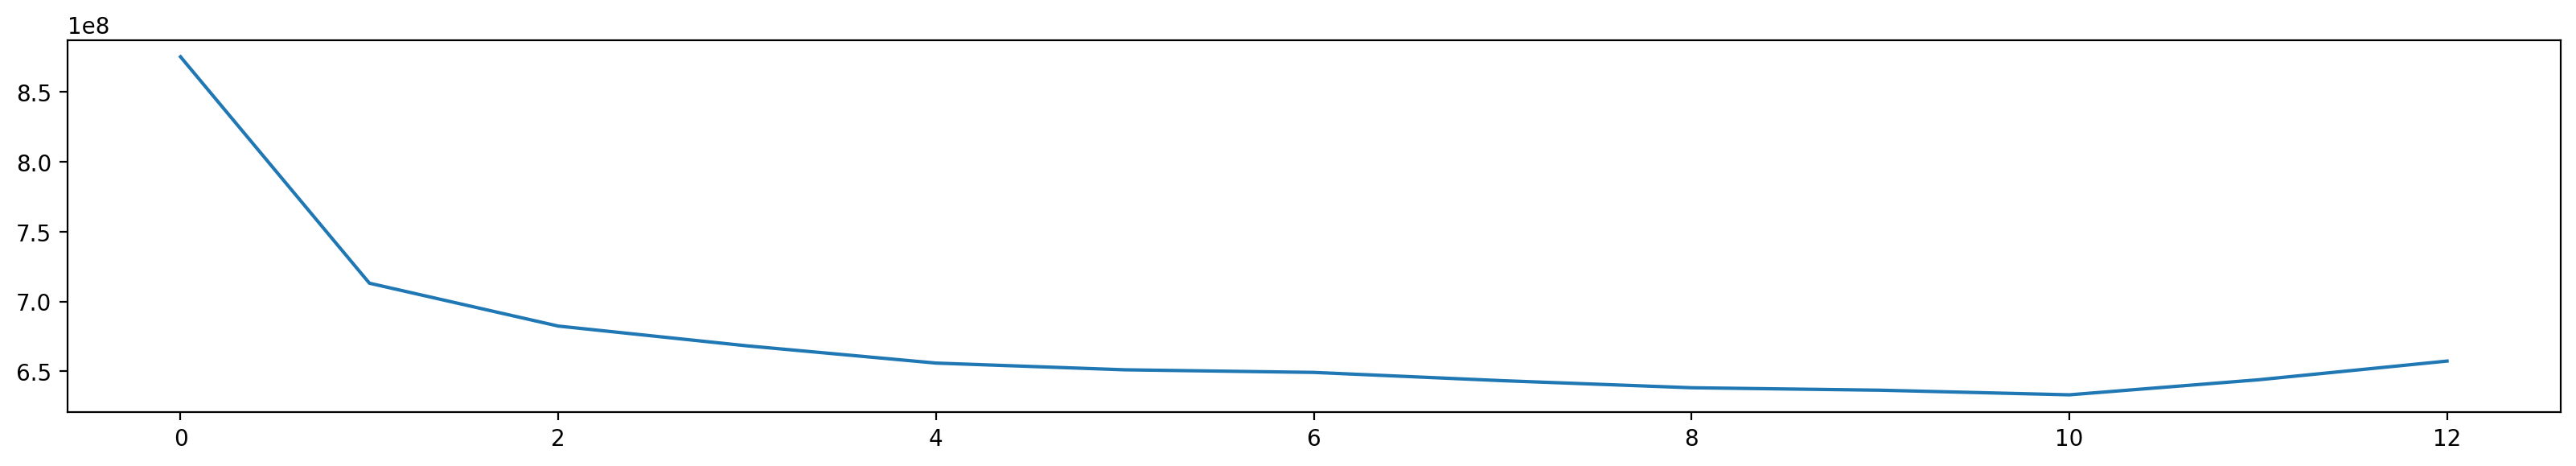

In [75]:
plt.plot(vae.loss_during_training)

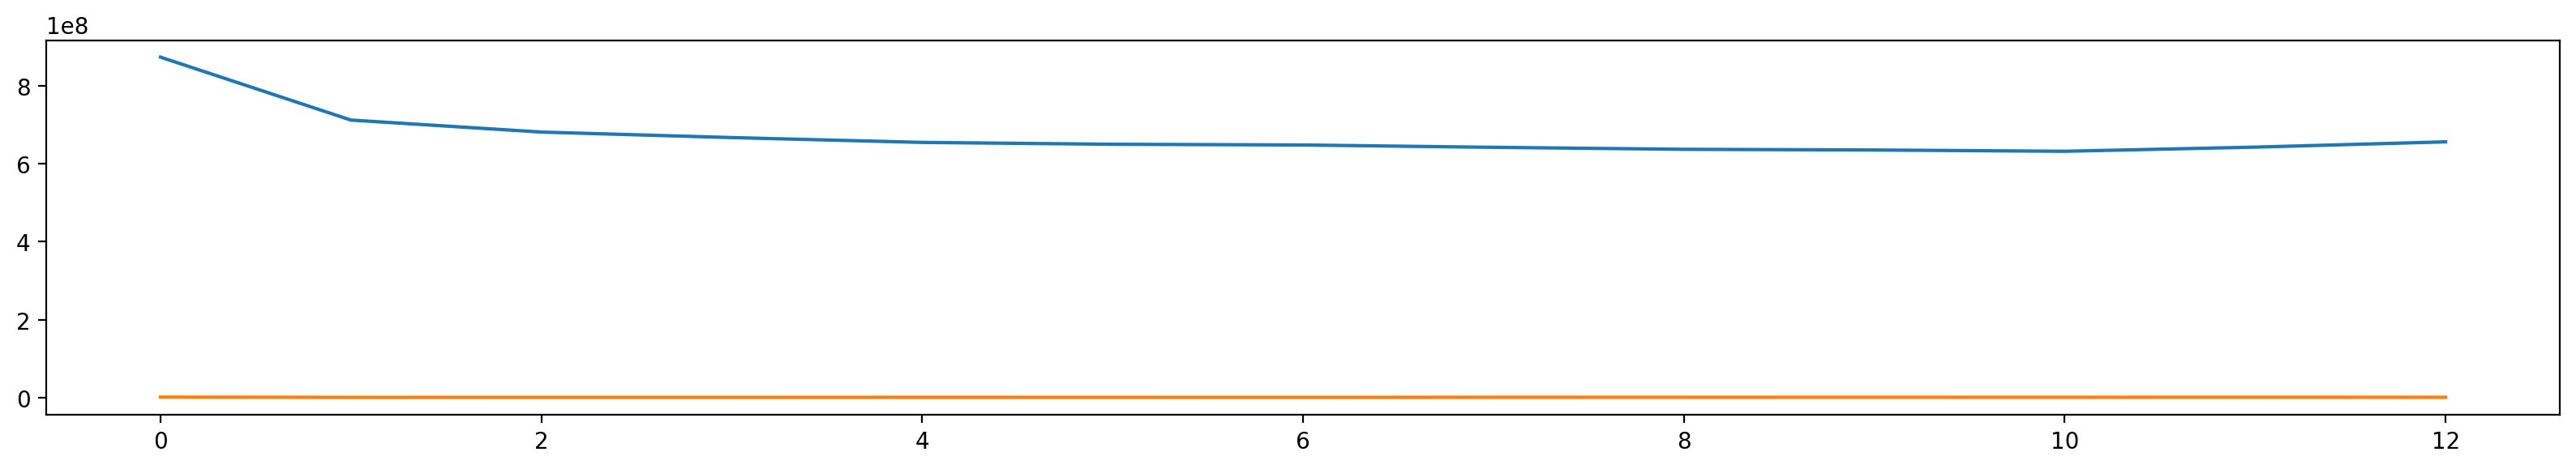

In [76]:
plt.plot(vae.reconstruc_during_training)
plt.plot(vae.KL_during_training)
plt.show()

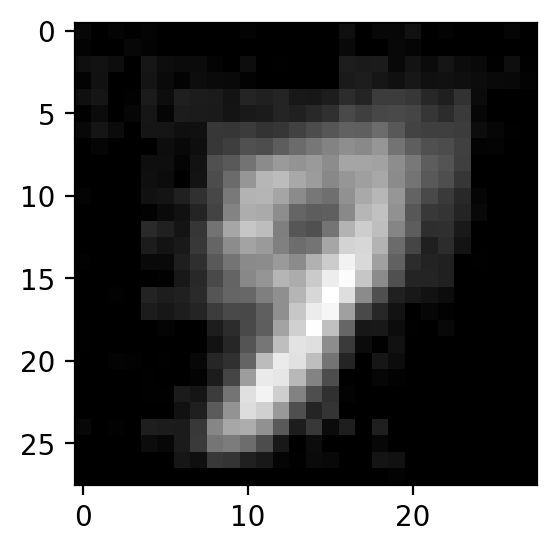

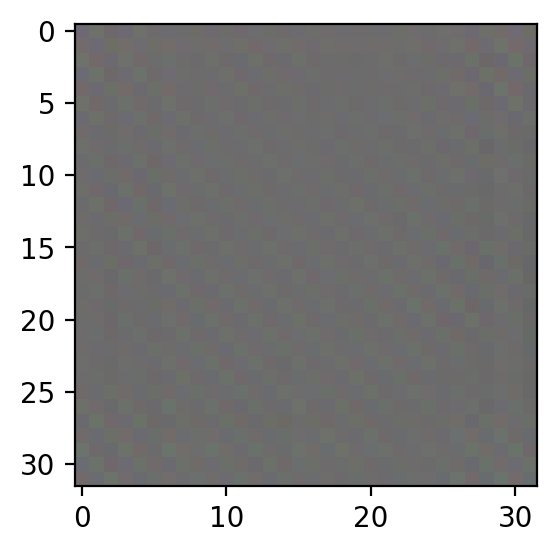

In [110]:
x1, x2 = vae.sample(1)
plt.imshow(x1[0].permute(1,2,0), cmap='gray')
plt.show()
plt.imshow(x2[0].permute(1,2,0))
plt.show()

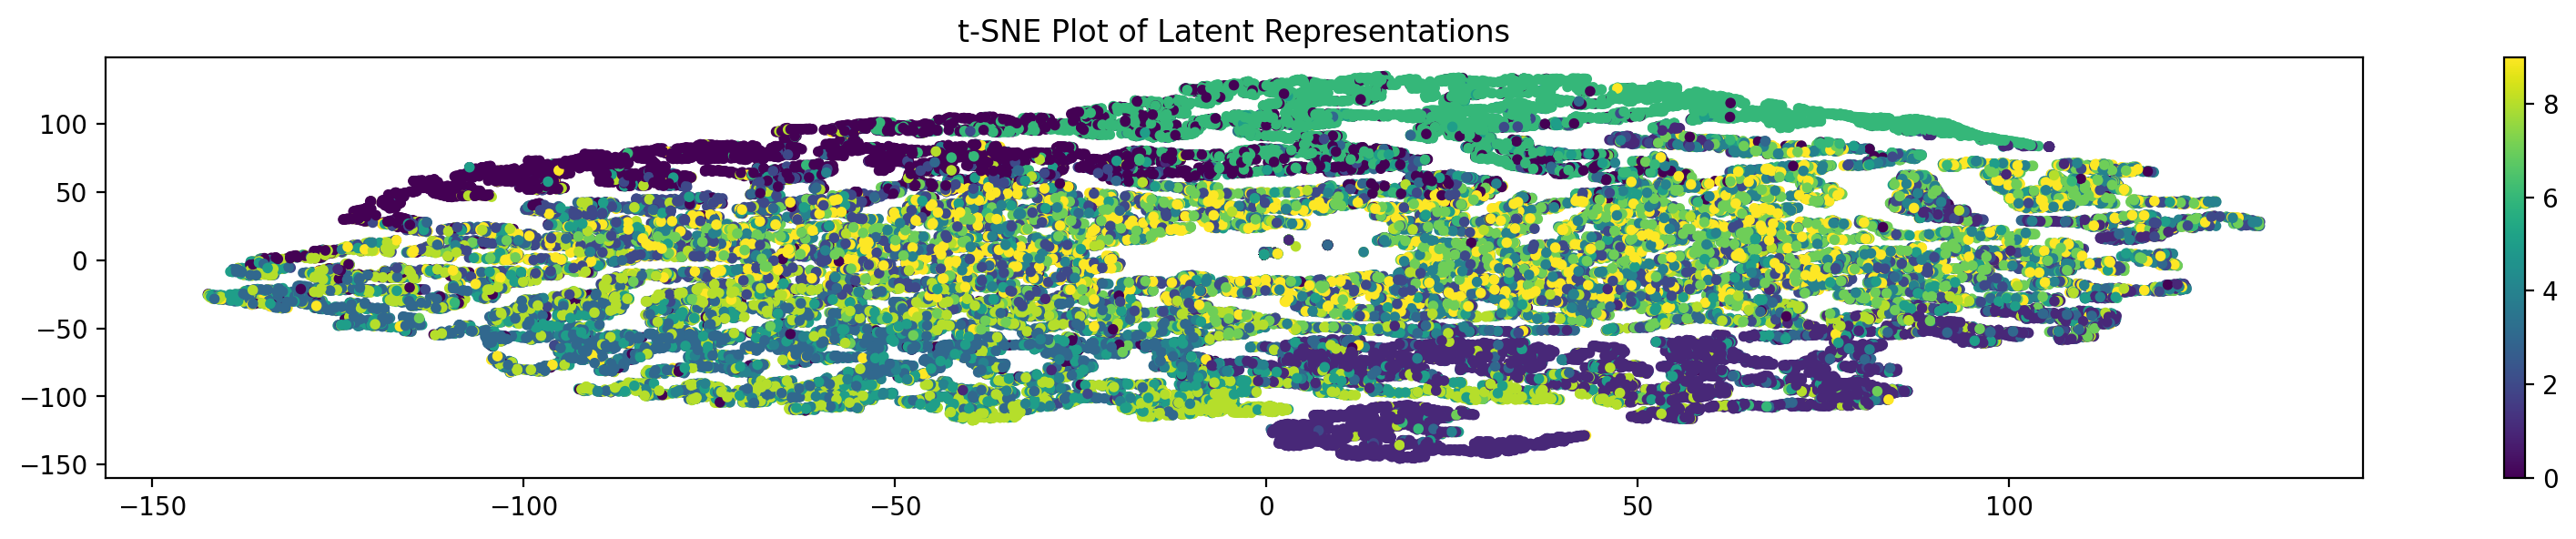

In [78]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Assuming you have a trained VAE model (vae) and a DataLoader (dataloader)

# Set the model to evaluation mode
vae.eval()

# Lists to store latent representations and corresponding labels
reconst = []
labels = []

# Loop through the dataset and obtain latent representations
with torch.no_grad():
    for images, labels_batch in dataloader:
        images_mnist, images_svhn = images
        images_mnist = images_mnist.to(vae.device)
        images_svhn = images_svhn.to(vae.device)
        
        _, mu_z, _ = vae.encoder.encode_and_sample(images_mnist, images_svhn)
        reconst.append(mu_z.cpu().numpy())
        labels.append(labels_batch.cpu().numpy())

# Concatenate lists to obtain a single array
reconst = np.concatenate(reconst, axis=0)
labels = np.concatenate(labels, axis=0)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(reconst)

# Plot the t-SNE representation
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis', s=10)
plt.title('t-SNE Plot of Latent Representations')
plt.colorbar()
plt.show()


In [79]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def cross_generate(direction_mnist: bool):
    # Set the model to evaluation mode
    vae.eval()

    # Lists to store latent representations and corresponding labels
    reconst = []
    labels = []

    # Loop through the dataset and obtain latent representations
    with torch.no_grad():
        for images, labels_batch in dataloader:
            images_mnist, images_svhn = images
            images_mnist = images_mnist.to(vae.device)
            images_svhn = images_svhn.to(vae.device)
            
            _, _, sample = vae.encoder.encode_and_sample(images_mnist, images_svhn)
            mnist, svhn = vae.decoder.decode(sample)
            if direction_mnist:
                reconst.append(mnist.cpu().numpy())
            else:
                reconst.append(svhn.cpu().numpy())
            labels.append(labels_batch.cpu().numpy())
            break # one batch only

    # Concatenate lists to obtain a single array
    reconst = np.concatenate(reconst, axis=0)
    labels = np.concatenate(labels, axis=0)

    sample_id = np.random.randint(0,labels.shape[0])
    plt.imshow(reconst[sample_id].transpose(1,2,0), cmap='gray')
    print(labels[sample_id])



9


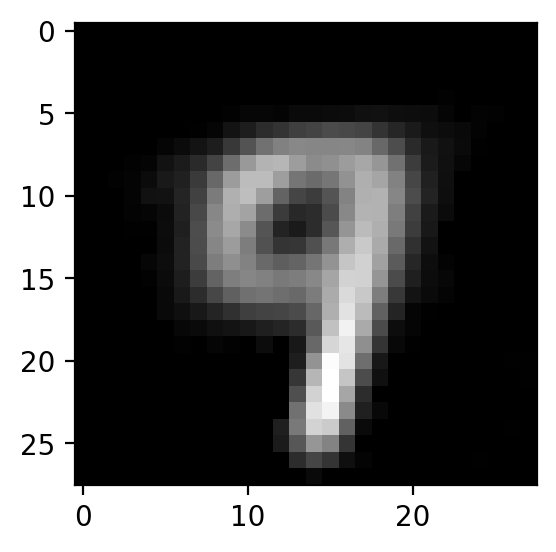

In [87]:
cross_generate(direction_mnist=True)